# TENSORFLOW

In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

tf.__version__

2023-12-07 23:21:40.751511: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-07 23:21:40.904676: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-07 23:21:41.722038: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


'2.13.0'

In [4]:
# keras.__version__

### import and split

In [5]:
fashion_mnist = keras.datasets.fashion_mnist
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist.load_data()

In [6]:
print(X_train_full.shape)
print(X_test.shape)

(60000, 28, 28)
(10000, 28, 28)


In [7]:
print(X_train_full.dtype)
print(y_train_full.shape)
print(y_test.shape)

uint8
(60000,)
(10000,)


### validation set (scales)

In [8]:
X_valid, X_train = X_train_full[:5000] / 255.0, X_train_full[5000:] / 255.0
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]

### labels

In [9]:
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]
class_names[y_train[0]]


'Coat'

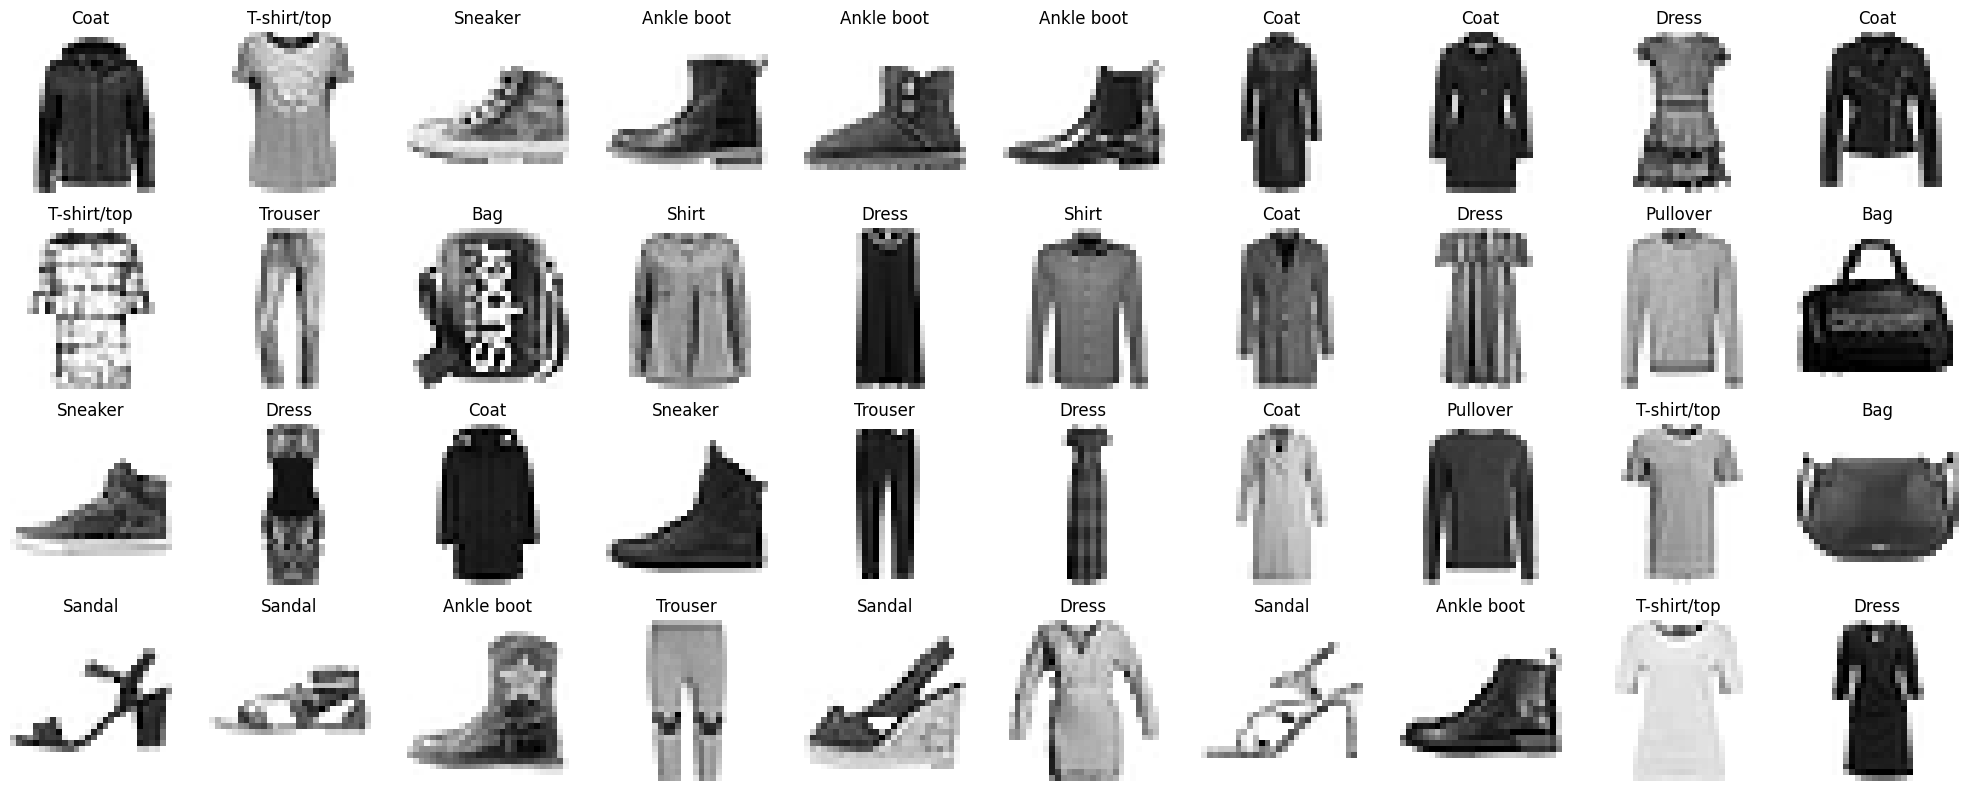

In [10]:

# specify the number of rows and columns you want to see
num_row = 4
num_col = 10

# get a segment of the dataset
num = num_row * num_col
images = X_train[:num]
labels = y_train[:num]

# plot images
fig, axes = plt.subplots(num_row, num_col, figsize=(2*num_col, 2*num_row))
for i in range(num):
    ax = axes[i//num_col, i % num_col]
    ax.imshow(images[i], cmap='binary')
    ax.set_title(np.array(class_names)[labels[i]])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.axis('off')

plt.tight_layout()
plt.show()


### creating the model using the Sequential API

In [13]:
model = keras.models.Sequential([
    # keras.layers.InputLayer(input_shape=[28, 28]),
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(10, activation="softmax")
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 784)               0         
                                                                 
 dense_3 (Dense)             (None, 300)               235500    
                                                                 
 dense_4 (Dense)             (None, 100)               30100     
                                                                 
 dense_5 (Dense)             (None, 10)                1010      
                                                                 
Total params: 266610 (1.02 MB)
Trainable params: 266610 (1.02 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [14]:
model.layers

In [17]:
hidden1 = model.layers[1]

model.get_layer('dense_4') is hidden1

False

In [18]:
weights, biases = hidden1.get_weights()

In [19]:
weights.shape

(784, 300)

In [20]:
biases.shape

(300,)

### Compiling the model

In [23]:
model.compile(loss="sparse_categorical_crossentropy",
              # optimizer="sgd", 
              optimizer=keras.optimizers.SGD(learning_rate=0.01),
              metrics=["accuracy"])


### Training and evaluating the model

#### callbacks

In [24]:
import os
import time

root_logdir = os.path.join(os.curdir, "logs")

def get_run_logdir():
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)

run_logdir = get_run_logdir()  # e.g., './my_logs/run_2019_06_07-15_15_22'

In [26]:
class PrintValTrainRatioCallback(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        print("\nval/train: {:.2f}".format(logs["val_loss"] / logs["loss"]))

checkpoint_cb = keras.callbacks.ModelCheckpoint("keras_model.h5", save_best_only=True)

early_stopping_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

'''  TensorBoard for Visualization  '''
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)

In [27]:
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid), 
                    callbacks=[PrintValTrainRatioCallback(), checkpoint_cb, early_stopping_cb, tensorboard_cb])


Epoch 1/10


2023-12-07 23:27:05.207651: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-12-07 23:27:05.364971: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fc0cc385a00 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-12-07 23:27:05.364988: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 6GB Laptop GPU, Compute Capability 8.6
2023-12-07 23:27:05.384537: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2023-12-07 23:27:05.418326: W tensorflow/compiler/xla/service/gpu/llvm_gpu_backend/gpu_backend_lib.cc:543] Can't find libdevice directory ${CUDA_DIR}/nvvm/libdevice. This may result in compilation or runtime failures, if the program we try to run uses routines from libdevice.
Searched for CUDA in the following directories:
  ./cuda_sd

   1/1719 [..............................] - ETA: 23:50 - loss: 2.3115 - accuracy: 0.1562WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0012s vs `on_train_batch_end` time: 0.0019s). Check your callbacks.


1700/1719 [============================>.] - ETA: 0s - loss: 0.7277 - accuracy: 0.7622
val/train: 0.75
1719/1719 [==============================] - 3s 1ms/step - loss: 0.7253 - accuracy: 0.7627 - val_loss: 0.5436 - val_accuracy: 0.8078
Epoch 2/10
 116/1719 [=>............................] - ETA: 2s - loss: 0.5516 - accuracy: 0.8128

/home/ange/anaconda3/envs/cuda-env/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1694/1719 [============================>.] - ETA: 0s - loss: 0.4917 - accuracy: 0.8290
val/train: 0.92
1719/1719 [==============================] - 2s 1ms/step - loss: 0.4907 - accuracy: 0.8296 - val_loss: 0.4525 - val_accuracy: 0.8472
Epoch 3/10
1706/1719 [============================>.] - ETA: 0s - loss: 0.4465 - accuracy: 0.8422
val/train: 0.96
1719/1719 [==============================] - 2s 1ms/step - loss: 0.4465 - accuracy: 0.8423 - val_loss: 0.4270 - val_accuracy: 0.8554
Epoch 4/10
1719/1719 [==============================] - ETA: 0s - loss: 0.4181 - accuracy: 0.8526
val/train: 0.95
1719/1719 [==============================] - 2s 1ms/step - loss: 0.4181 - accuracy: 0.8526 - val_loss: 0.3993 - val_accuracy: 0.8644
Epoch 5/10
1712/1719 [============================>.] - ETA: 0s - loss: 0.3969 - accuracy: 0.8600
val/train: 0.99
1719/1719 [==============================] - 2s 1ms/step - loss: 0.3967 - accuracy: 0.8599 - val_loss: 0.3939 - val_accuracy: 0.8626
Epoch 6/10
1678/1719 [=

In [28]:
%load_ext tensorboard
%tensorboard --logdir=./logs --port=6006

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 330365), started 0:01:10 ago. (Use '!kill 330365' to kill it.)

In [29]:
!tensorboard --logdir='./logs/run_2023_05_02-03_57_40' --port=6006

2023-12-07 23:53:35.097723: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-07 23:53:35.124399: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-07 23:53:35.551556: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-12-07 23:53:36.108193: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.

### Learning curves

In [30]:
history

In [31]:
import pandas as pd

history_df = pd.DataFrame(history.history)
history_df.head()

,loss,accuracy,val_loss,val_accuracy
0,0.725292,0.762691,0.543580,0.8078
1,0.490683,0.829636,0.452495,0.8472
2,0.446496,0.842291,0.427038,0.8554
3,0.418130,0.852564,0.399312,0.8644
4,0.396734,0.859927,0.393945,0.8626


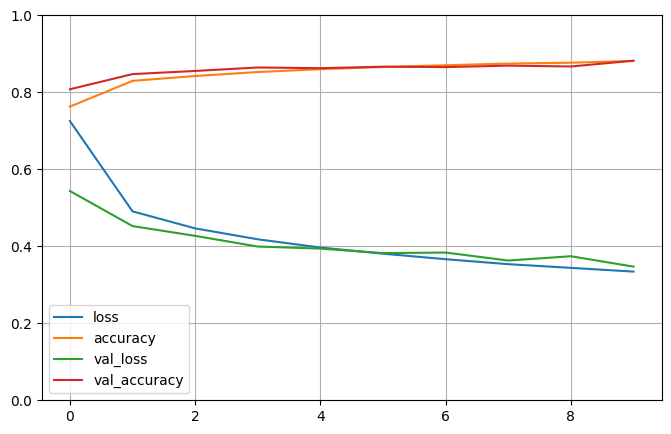

In [32]:
history_df.plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)  # set the vertical range to [0-1]
plt.show()

### test

In [33]:
model.evaluate(X_test, y_test)

313/313 [==============================] - 0s 799us/step - loss: 68.1182 - accuracy: 0.8309


[68.11820983886719, 0.8309000134468079]

### predictions

In [34]:
X_new = X_test[:3]
y_proba = model.predict(X_new)
y_proba.round(2)

1/1 [==============================] - 0s 44ms/step


array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

In [35]:
y_pred=model.predict(X_new) 
y_classes=np.argmax(y_pred,axis=1)

y_label = np.array(class_names)[y_classes]

y_label


1/1 [==============================] - 0s 12ms/step


array(['Ankle boot', 'Pullover', 'Trouser'], dtype='<U11')

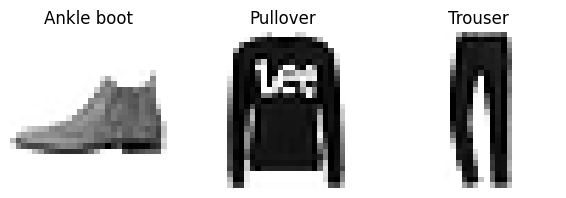

In [36]:
# specify the number of rows and columns you want to see
num_row = 1
num_col = 3

# get a segment of the dataset
num = num_row * num_col
images = X_new[:num]
labels = y_label[:num]

# plot images
fig, axes = plt.subplots(num_row, num_col, figsize=(2*num_col, 2*num_row))
for i in range(num):
    ax = axes[i]
    ax.imshow(images[i], cmap='binary')
    ax.set_title(labels[i])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.axis('off')

plt.tight_layout()
plt.show()

## Saving and Restoring a Model

In [37]:
model.save("keras_model.h5")

/home/ange/anaconda3/envs/cuda-env/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [38]:
model = keras.models.load_model("keras_model.h5")

### evaluation

In [39]:
model.evaluate(X_test, y_test)

313/313 [==============================] - 0s 833us/step - loss: 68.1182 - accuracy: 0.8309


[68.11820983886719, 0.8309000134468079]

In [40]:
import tensorflow.compat.v1 as t1
t1.__version__
AUTOTUNE = tf.data.AUTOTUNE
AUTOTUNE


-1